In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import scipy
import torch.nn.functional as F
import copy
from torch import nn
from torch import optim
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import ChebConv
from torch.nn import Module, Parameter

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Variational Graph AutoEncoder

In [3]:
def sparse_degree_matrix(A) -> torch.sparse.FloatTensor:
    D = scipy.sparse.spdiags(torch.sparse.sum(A, dim=1).to_dense(),0, *A.shape).tocoo()
    return coo_to_torch_sparse_matrix(D)

In [4]:
def coo_to_torch_sparse_matrix(coo):
    idx = torch.LongTensor(coo.nonzero())
    data = torch.FloatTensor(coo.data)
    return torch.sparse.FloatTensor(idx, data)

In [5]:
def laplacian(A, normalized=True):
    I = torch.eye(A.shape[0])
    D = sparse_degree_matrix(A)
    if not normalized:
        L = D.sub(A)
    else:
        D = (D**(-0.5)).to_dense()
        p1 = torch.spmm(A, D)
        L = torch.mm(p1, D)
        # L = coo_to_torch_sparse_matrix(scipy.sparse.coo_matrix(I - p2))

    return L

In [6]:
M_test = torch.sparse.FloatTensor(data.edge_index, torch.FloatTensor(np.repeat(1, len(data.edge_index[1]))))
L = laplacian(M_test)

In [7]:
class GraphConvolutionLayer(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """
    def __init__(self, in_features, out_features):
        super(GraphConvolutionLayer, self).__init__()
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = Parameter(torch.FloatTensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        return output + self.bias

In [8]:
class VGAE(Module):
    def __init__(self, nfeat, nhid, n_samples):
        super(VGAE, self).__init__()
        self.n_samples = n_samples
        self.nhid = nhid
        self.gc1 = GraphConvolutionLayer(nfeat, nhid)
        self.gc2mu = GraphConvolutionLayer(nhid, nhid)
        self.gc2std = GraphConvolutionLayer(nhid, nhid)
        
    def forward(self, x, adj):
        # First GCN
        x = F.relu(self.gc1(x, adj))
        # Mean and std
        self.mean = self.gc2mu(x, adj)
        self.log_std = self.gc2std(x, adj)
        # Latent representation
        self.z = self.mean + torch.mul(self.log_std, torch.randn_like(self.log_std))
        # Decoder
        return torch.sigmoid(torch.mm(self.z, self.z.t()))
    
    def loss(self, A_hat, A):
        # Binary Crossentropy loss
        bce_loss = nn.BCELoss(reduce='sum')(A_hat, A)
        # KL Loss
        # kl_loss = - 0.5 * torch.mean(torch.sum(1 + self.log_std - self.mean.pow(2) - self.log_std.exp(), dim=1)) 
        kl_loss = nn.KLDivLoss(reduce='batchmean')(torch.log(A_hat), A)
        
        return bce_loss + kl_loss
        

In [9]:
vgae = VGAE(1433, 200, data.x.shape[0])
optimizer = optim.Adam(vgae.parameters())

In [10]:
import tqdm
loss_history = np.zeros(100) 

for epoch in tqdm.trange(100): 
  
    optimizer.zero_grad()
    outputs = vgae(torch.eye(*data.x.shape), L)
    loss = vgae.loss(outputs, L)
    loss.backward()
    optimizer.step()

    loss_history[epoch] = loss.detach().numpy()

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1946: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


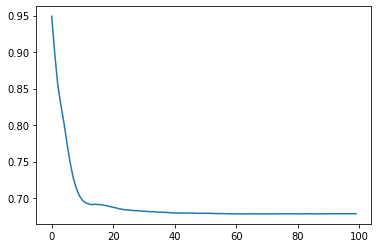

0.9490655660629272
0.6786467432975769
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3333, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2500],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2500, 0.0000]])
tensor([[0.5130, 0.5013, 0.4940,  ..., 0.5020, 0.5009, 0.5018],
        [0.5013, 0.5156, 0.5037,  ..., 0.4989, 0.4982, 0.4997],
        [0.4940, 0.5037, 0.5463,  ..., 0.4899, 0.4936, 0.4971],
        ...,
        [0.5020, 0.4989, 0.4899,  ..., 0.5133, 0.5022, 0.5000],
        [0.5009, 0.4982, 0.4936,  ..., 0.5022, 0.5129, 0.4999],
        [0.5018, 0.4997, 0.4971,  ..., 0.5000, 0.4999, 0.5120]])


In [11]:
plt.plot(loss_history)
plt.show()
print(loss_history[0])
print(loss_history[len(loss_history) -1])
print(L, outputs.data, sep='\n')

## GCN vs VGAE

In [12]:
def test(model, A):
    model.eval()
    _, pred = model(data.x, A).max(dim=1)
    correct = float (pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / data.test_mask.sum().item()
    print('Accuracy: {:.4f}'.format(acc))

In [13]:
class GCN(Module):
    def __init__(self, nfeat, nhid, nclass):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolutionLayer(nfeat, nhid)
        self.gc2 = GraphConvolutionLayer(nhid, nclass)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [14]:
VGAE_A = outputs.data.clone()

In [15]:
gcn1 = GCN(1433, 50, 7)
gcn2 = GCN(1433, 50, 7)
optimizer_gcn_1 = optim.Adam(gcn1.parameters())
optimizer_gcn_2 = optim.Adam(gcn2.parameters())
criterion = nn.CrossEntropyLoss()

### GCN

In [ ]:
del loss_history, loss, outputs

import tqdm
loss_history = np.zeros(2500) 

for epoch in tqdm.trange(2500): 
  
    optimizer_gcn_1.zero_grad()
    outputs = gcn1(data.x, L) # Usiamo tutto il dataset
    loss = criterion(outputs[data.train_mask], data.y[data.train_mask]) # Mascheriamo sulla parte di training
    loss.backward()
    optimizer_gcn_1.step()

    loss_history[epoch] = loss.detach().numpy()

In [ ]:
plt.plot(loss_history)
plt.show()

In [ ]:
print(loss_history[len(loss_history) -1])
test(gcn1, L)

### VGAE

In [16]:
del loss_history, loss, outputs

import tqdm
loss_history = np.zeros(1000) 

for epoch in tqdm.trange(1000): 
  
    optimizer_gcn_2.zero_grad()
    outputs = gcn2(data.x, VGAE_A) # Usiamo tutto il dataset
    loss = criterion(outputs[data.train_mask], data.y[data.train_mask]) # Mascheriamo sulla parte di training
    loss.backward()
    optimizer_gcn_2.step()

    loss_history[epoch] = loss.detach().numpy()

100%|██████████| 1000/1000 [00:36<00:00, 27.34it/s]


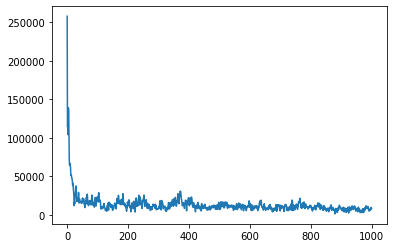

In [17]:
plt.plot(loss_history)
plt.show()

In [18]:
print(loss_history[len(loss_history) -1])
test(gcn2, VGAE_A)

8151.62939453125
Accuracy: 0.1490
